# Colors for SNLS

- Author Sylvie Dagoret-Campagne
- date March 23rd 2018
- update Jun 4th 2018

Process SED with/without galactic extinction
- picke catalog


In [249]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
import numpy as np
import pandas as pd
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
cmap = cm.jet
%matplotlib inline

In [251]:
import os
import sys

In [252]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [253]:
top_pysynphot_data_dir=os.environ['PYSYN_CDBS']

In [254]:
cfht_transmissionfile="./all_SNLS_transm.csv"

In [255]:
sys.path.append('./snlsphotometry')
sys.path.append('../DESCDec2017/pysynphotsed')

In [256]:
!ls ../DESCDEC2017

CheckSEDmodels  Impact_ozone    README.md       lsstphotometry  tests_aerosols
Impact_Airmass  Impact_pwv      SEDPopulations  pysynphotsed    tests_ozone
Impact_aerosols LSSTFiltersKG   libradtransim   test_pwv


In [257]:
import libSNLSPhotometry as photo
import libCFHTFilters as cfht
#import libpysynphotsed as sed
import libpysynphotgridsed as sed

In [258]:
import astropy
import astropy.units as u
from astropy.io import fits

In [259]:
import pysynphot as S
S.primary_area=1.02e5
S.binning=1.

# CFHT Telescope

In [260]:
CFHT_COLL_SURF=np.pi/4.*(3.6*u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [261]:
NBINS=int(WLMAX-WLMIN)
BinWidth=(WLMAX-WLMIN)/float(NBINS)
WL=np.linspace(WLMIN,WLMAX,NBINS)

In [262]:
CFHT_COLL_SURF.decompose()

<Quantity 101787.6019763093>

In [263]:
S.refs.setref(area=CFHT_COLL_SURF.decompose(), waveset=None)

In [264]:
#S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMIN, num=NBINS, delta=1, log=False)
# bad effect on AB source

In [265]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 101787.601976


# catalogs of sources

## Calibration source

The calibration source is flat in $f\nu$.

In [266]:
f0=10**(S.units.ABZERO/2.5)

In [267]:
calib_source=S.FlatSpectrum(f0,fluxunits='fnu')
print calib_source.flux
print calib_source.wave
calib_source.convert('flam')

[  3.63078055e-20   3.63078055e-20   3.63078055e-20 ...,   3.63078055e-20
   3.63078055e-20   3.63078055e-20]
[  3000.   3001.   3002. ...,  10997.  10998.  10999.]


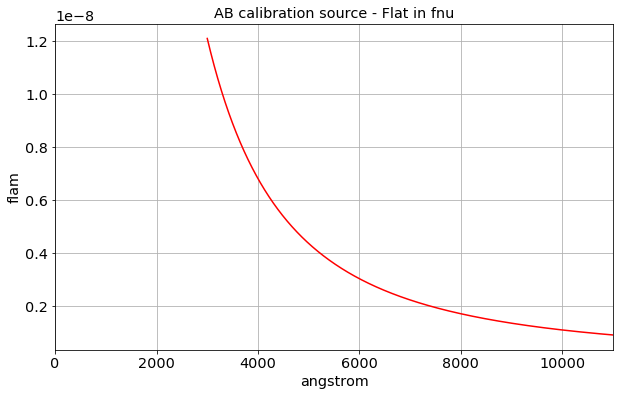

In [268]:
plt.plot(calib_source.wave,calib_source.flux,'r-')
plt.xlabel(calib_source.waveunits)
plt.ylabel(calib_source.fluxunits)
plt.title("AB calibration source - Flat in fnu")
#plt.ylim(0,2000.)
plt.xlim(0.,11000.)
plt.grid()

## Catalog of sources

- please change the name

In [269]:
file_sed_fits='sedgrid_pickle_uvi_selected.fits'
file_out_magnitudes="pickle_uvi_snlsmagnit_Noextinct.csv"
file_out_colors="pickle_uvi_snlscol_Noextinct.csv"
file_out_magandcol="pickle_uvi_snlsmagcol_Noextinct.csv"
tag_sed='pickle_uvi'

## Fill two catalogs

In [270]:
all_sed_collection= []
all_sedmodels_tag=[]

In [271]:
Flag_AB=True
Flag_PICKLES=True

    
if Flag_PICKLES:
    all_sed,all_indexes=sed.FitsToPySynphotSED(file_sed_fits)
    all_sed_collection.append(all_sed)
    all_sedmodels_tag.append(tag_sed)
    
if Flag_AB:    
    all_sed_collection.append([calib_source])
    all_sedmodels_tag.append('AB-source')
        

In [272]:
NBCATALOGS=len(all_sedmodels_tag)

In [273]:
NBCATALOGS

2

In [274]:
print len(all_indexes)

131


# Retrieve Filters

In [275]:
bp_u,bp_g,bp_r,bp_i,bp_z=cfht.GetAllCFHTBands(cfht_transmissionfile)

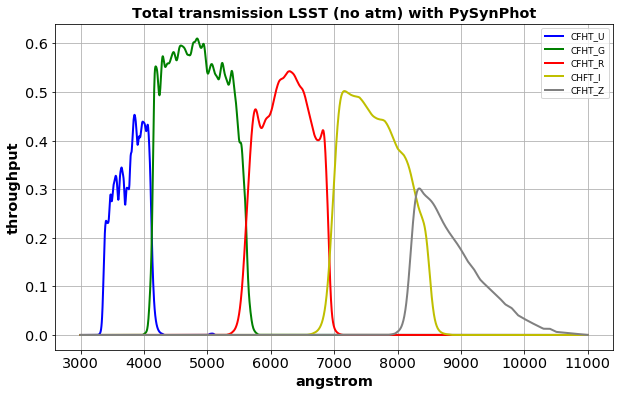

In [276]:
cfht.PlotAllCFHTBands(bp_u,bp_g,bp_r,bp_i,bp_z)

# Create LSST Detector

In [277]:
cfhtdetector=photo.SNLSTransmission('cfhtel')

In [278]:
cfhtdetector.fill_det_allbands([bp_u,bp_g,bp_r,bp_i,bp_z])

# Get CFHT Atmosphere

In [279]:
photo_atm=photo.Atmosphere('SNLS atmosphere')

In [280]:
df=pd.read_csv(cfht_transmissionfile)
df.sort_index(axis=0,ascending=True,inplace=True)     
wl_atm=df["lambda"]
tr_atm=df["atm"]
wl_atm=np.array(wl_atm)   
tr_atm=np.array(tr_atm)
photo_atm.fill_array(wl_atm)        
photo_atm.fill_array(tr_atm)  

In [281]:
theatmosph=photo_atm.get_array()

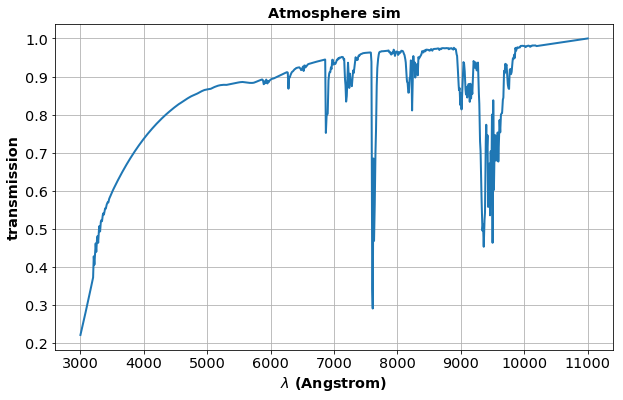

In [282]:
photo_atm.plot_pys_bp()

In [283]:
all_bp_atm=photo_atm.get_pys_pb()

In [284]:
cfhtdetector.fill_atm_allevents(all_bp_atm)

In [285]:
all_transmissions=cfhtdetector.make_transmissions()

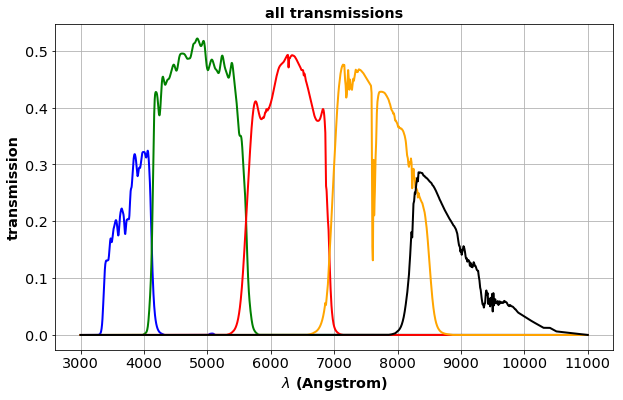

In [286]:
cfhtdetector.plot_transmissions()

# Calculation of all Observations for each SED colors

In [287]:
all_observations_collection = []
all_observations_zeropt_collection = []

In [288]:
np.arange(NBCATALOGS)

array([0, 1])

In [289]:
for id_model in np.arange(NBCATALOGS):
    the_obs_name="SNLS_models-{}".format(all_sedmodels_tag[id_model])  
    print id_model, the_obs_name
    the_observation=photo.SNLSObservation(the_obs_name)            # create a set of observation 
    the_observation.fill_sed(all_sed_collection[id_model])         # get the SED from the SED model model
    the_observation.fill_transmission(all_transmissions)           # provide LSST Trroughput transmission
    the_observation.make_observations()                            # start calculations 
    the_observation.make_samplobservations()
    the_observation.compute_counts()
    the_observation.compute_magnitude()
    the_observation.compute_colors()
    all_observations_collection.append(the_observation)

0 SNLS_models-pickle_uvi
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.

((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does 

((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does 

((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does 

((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does 

((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does 

((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CFHT_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * CHFT_I)) does 

# Check

In [290]:
len(all_observations_collection)

2

In [291]:
ModelSelect=0
ObjectSelect=0

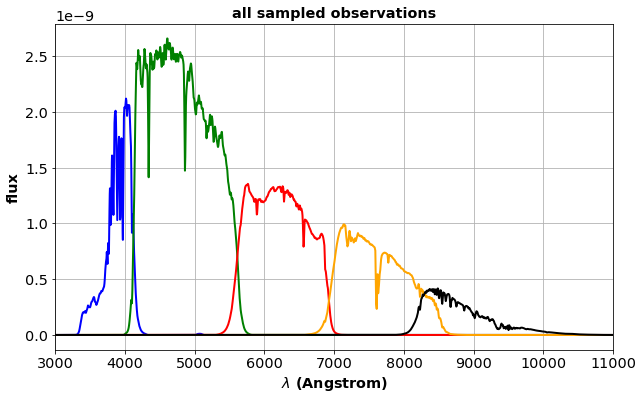

In [292]:
all_observations_collection[ModelSelect].plot_samplobservations(ObjectSelect)

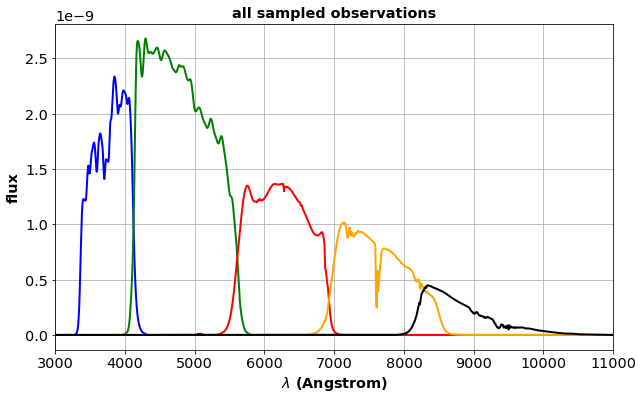

In [293]:
all_observations_collection[1].plot_samplobservations(ObjectSelect)

# Work with magnitudes

In [294]:
all_magnitudes=np.array(all_observations_collection[ModelSelect].get_magnitudes())

In [295]:
all_magnitudes_ref=np.array(all_observations_collection[1].get_magnitudes())

In [296]:
print len(all_indexes)

131


In [297]:
type(all_magnitudes)

numpy.ndarray

In [298]:
all_magnitudes0=all_magnitudes[:,0,:]

In [299]:
all_magnitudes0.shape

(131, 5)

In [300]:
all_magnitudes0_ref=all_magnitudes_ref[:,0,:]

In [301]:
all_magnitudes0_ref.shape

(1, 5)

In [302]:
all_magnitudes0_ref

array([[-26.06760653, -27.24748716, -26.74820357, -26.58911675,
        -25.63274768]])

In [303]:
calibrated_magnitudes0=all_magnitudes0-all_magnitudes0_ref

In [304]:
dfm=pd.DataFrame(data=calibrated_magnitudes0,columns=["u","g","r","i","z"])

In [305]:
dfm.head()

,u,g,r,i,z
0,0.658451,0.017092,0.035741,0.073975,0.091179
1,3.031274,0.597573,-0.448687,-0.873407,-1.112498
2,1.568057,0.302793,-0.240510,-0.446376,-0.502341
3,1.835888,0.358270,-0.223153,-0.343228,-0.334685
4,3.382734,0.663435,-0.533146,-1.271744,-1.610965


In [306]:
dfm["idxcat"]=all_indexes
dfm=dfm.reindex(['idxcat','u','g','r','i','z'], axis=1)

In [307]:
dfm.head()

,idxcat,u,g,r,i,z
0,1,0.658451,0.017092,0.035741,0.073975,0.091179
1,2,3.031274,0.597573,-0.448687,-0.873407,-1.112498
2,3,1.568057,0.302793,-0.240510,-0.446376,-0.502341
3,4,1.835888,0.358270,-0.223153,-0.343228,-0.334685
4,5,3.382734,0.663435,-0.533146,-1.271744,-1.610965


In [308]:
dfm.to_csv(file_out_magnitudes)

# Work with colors

In [309]:
all_colors=all_observations_collection[ModelSelect].get_colors()
all_color_ref=all_observations_collection[1].get_colors()

In [310]:
all_colors.shape

(131, 1, 4)

In [311]:
all_color_ref.shape

(1, 1, 4)

In [312]:
all_color_ref

array([[[ 1.17988062, -0.49928359, -0.15908682, -0.95636907]]])

131 131
1 1


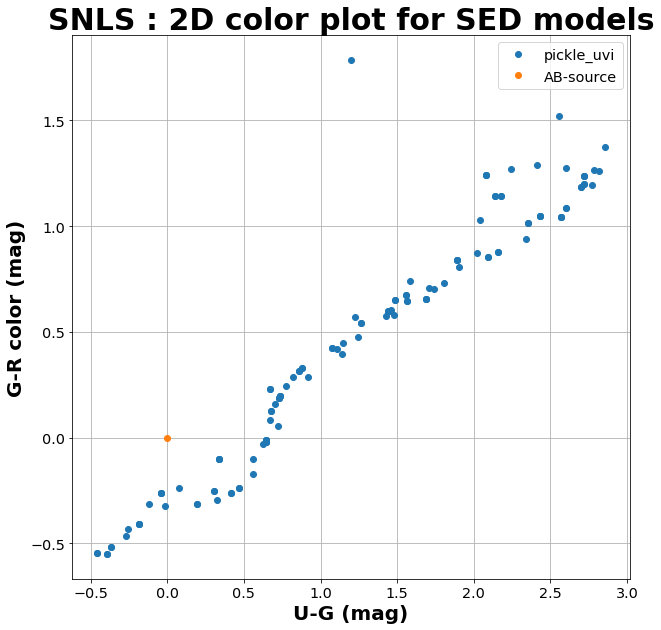

In [313]:
plt.figure(figsize=(10,10))
for id_model in np.arange(NBCATALOGS):
    all_colors=all_observations_collection[id_model].get_colors()
    c1=all_colors[:,0,0]-all_color_ref[0,0,0]
    c2=all_colors[:,0,1]-all_color_ref[0,0,1]
    print len(c1),len(c2)
    plt.plot(c1,c2,'o',label=all_sedmodels_tag[id_model])
    
plt.grid()

xtitle='U-G (mag)'
ytitle='G-R color (mag)'
title='SNLS : 2D color plot for SED models'
plt.xlabel(xtitle,fontsize=20,weight='bold')
plt.ylabel(ytitle,fontsize=20,weight='bold')        
plt.title(title,fontsize=30,weight='bold')    
plt.legend()    
    

In [314]:
id_phoenix_model=0
all_colors=all_observations_collection[id_phoenix_model].get_colors()
c1=all_colors[:,0,0]-all_color_ref[0,0,0]
c2=all_colors[:,0,1]-all_color_ref[0,0,1]
c3=all_colors[:,0,2]-all_color_ref[0,0,2]
c4=all_colors[:,0,3]-all_color_ref[0,0,3]

In [315]:
dfc=pd.DataFrame({'u_g':c1,'g_r':c2,'r_i':c3,'i_z':c4})

In [316]:
dfc.head()

,g_r,i_z,r_i,u_g
0,-0.018649,-0.017204,-0.038234,0.641359
1,1.046260,0.239091,0.424720,2.433702
2,0.543303,0.055966,0.205865,1.265265
3,0.581424,-0.008543,0.120075,1.477618
4,1.196581,0.339221,0.738598,2.719300


In [317]:
dfc = dfc.reindex(['u_g','g_r','r_i','i_z'], axis=1)
#df = df.reindex(['u-g','g-r','r-i','i-z'], axis=1)
#dfc = df.reindex_axis(['u_g','g_r','r_i','i_z'], axis=1)

In [318]:
dfc.head()

,u_g,g_r,r_i,i_z
0,0.641359,-0.018649,-0.038234,-0.017204
1,2.433702,1.046260,0.424720,0.239091
2,1.265265,0.543303,0.205865,0.055966
3,1.477618,0.581424,0.120075,-0.008543
4,2.719300,1.196581,0.738598,0.339221


In [319]:
dfc.to_csv(file_out_colors)

## Merge magnitudes and colors

In [320]:
#file_out_magandcol="pickle_uvi_snlsmagcol_Noextinct.csv"

In [321]:
df=pd.concat([dfm, dfc], axis=1)

In [322]:
df.head()

,idxcat,u,g,r,i,z,u_g,g_r,r_i,i_z
0,1,0.658451,0.017092,0.035741,0.073975,0.091179,0.641359,-0.018649,-0.038234,-0.017204
1,2,3.031274,0.597573,-0.448687,-0.873407,-1.112498,2.433702,1.046260,0.424720,0.239091
2,3,1.568057,0.302793,-0.240510,-0.446376,-0.502341,1.265265,0.543303,0.205865,0.055966
3,4,1.835888,0.358270,-0.223153,-0.343228,-0.334685,1.477618,0.581424,0.120075,-0.008543
4,5,3.382734,0.663435,-0.533146,-1.271744,-1.610965,2.719300,1.196581,0.738598,0.339221


In [323]:
df.to_csv(file_out_magandcol)